In [28]:
%matplotlib inline
import numpy as np
from scipy.stats import binom
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import sys

Our setup:

Stimuli in our experiment have two dimensions X and Y that can be either True or False.

Subjects have to classify stimuli into two categories (A and B), defined as bivariate bernoulli distributions. Therefore each category can be defined by three parameters as follows (this example is an XOR category):

In [3]:
pA_00 = .5 #Probability of a category A stimulus being ~X and ~Y
pA_10 = 0 #Probability of a category A stimulus being X and ~Y
pA_01 = 0 #Probability of a category A stimulus being ~X and Y
pA_11 = 1 - (pA_00 + pA_10 + pA_01) #Probability of a category A stimulus being X and Y
cat_A = [[pA_00, pA_10], 
         [pA_01, pA_11]]

pB_00 = 0 
pB_10 = .5 
pB_01 = .5
pB_11 = 1 - (pB_00 + pB_10 + pB_01)
cat_B = [[pB_00, pB_10], 
         [pB_01, pB_11]]

Alternately, we can reparameterize the categories as a probability that X is True, probability that Y is true and the correlation between the two dimensions

In [5]:
A_X = .5 
A_Y = .5
A_rho = 1 #correlation

B_X = .5 
B_Y = .5
B_rho = -1

(This function converts back to the original representation)

In [6]:
def get_cat(pX, pY, rho):
    qX = 1 - pX
    qY = 1 - pY
    sigmaX = np.sqrt(pX * qX)
    sigmaY = np.sqrt(pY * qY)
    sigmaXY = rho * sigmaX * sigmaY
    p00 = (qX * qY) + sigmaXY
    p10 = (pX * qY) - sigmaXY
    p01 = (qX * pY) - sigmaXY
    p11 = (pX * pY) + sigmaXY
    cat = [[p00, p10], [p01, p11]]
    return cat

print get_cat(A_X, A_Y, A_rho)
print get_cat(B_X, B_Y, B_rho)

[[0.5, 0.0], [0.0, 0.5]]
[[0.0, 0.5], [0.5, 0.0]]


Now we need a prior over categories, we assume each category is equally likely for now:

In [7]:
p0 = .5

In the categorization task, subjects do not get to see the true stimulus but instead see several noisy samples of each stimulus dimension. These samples are independent and have Bernoulli noise. Here we assume that noise is .8

In [8]:
p = .8

Now we can compute the expected probability correct under an allocation N = [N_X, N_Y] using the optimal decision policy (which responds with whichever likelihood is greater). N_X is the number of samples allocated to category A. 

First we compute the probability of an outcome k = [k_X, k_Y]. k_X is the number of samples of dimension X that came out True.

In [36]:
def prob_k(k, N, cat_A, cat_B, p, p0):
    N_X, N_Y = N
    k_X, k_Y = k
    #Compute probabilities of k given that true stimulus takes on a certain value
    #Probability of k_X True samples is binomial with probability 1-p if the true stimulus is False
    prob_k_00 = binom.pmf(k_X, N_X, 1-p) * binom.pmf(k_Y, N_Y, 1-p)
    prob_k_10 = binom.pmf(k_X, N_X, p) * binom.pmf(k_Y, N_Y, 1-p)
    prob_k_01 = binom.pmf(k_X, N_X, 1-p) * binom.pmf(k_Y, N_Y, p)
    prob_k_11 = binom.pmf(k_X, N_X, p) * binom.pmf(k_Y, N_Y, p)
    
    #Now multiply by category probabilities to get probability of observing k under each category
    [[pA_00, pA_10], [pA_01, pA_11]] = cat_A
    [[pB_00, pB_10], [pB_01, pB_11]] = cat_B
    pA = ((pA_00 * prob_k_00) + 
          (pA_10 * prob_k_10) + 
          (pA_01 * prob_k_01) + 
          (pA_11 * prob_k_11))
    pB = ((pB_00 * prob_k_00) + 
          (pB_10 * prob_k_10) + 
          (pB_01 * prob_k_01) + 
          (pB_11 * prob_k_11))
    
    #Now the decision variable (positive if A is better, negative if B is better)
    d = p0 * pB - (1 - p0) * pA
    
    #Compute optimal response r: if r is 1, respond B, if r is 0, respond A and if r is .5 likelihoods are equal
    if abs(d) < sys.float_info.epsilon:
        r = .5
    else:
        r = int(d > 0)
    return pA, pB, r

Now compute expected probability correct under an allocation N if we use the optimal response:

In [33]:
def p_correct(N, cat_A, cat_B, p, p0):
    pAs = np.zeros((N[0] + 1, N[1] + 1))
    pBs = np.zeros((N[0] + 1, N[1] + 1))
    rs = np.zeros((N[0] + 1, N[1] + 1))
    
    #Compute probability and optimal response for all possible k values
    for k_0 in range(N[0] + 1):
        for k_1 in range(N[1] + 1):
            k = [k_0, k_1]
            pAs[k_0, k_1], pBs[k_0, k_1], rs[k_0, k_1] = prob_k(k, N, cat_A, cat_B, p, p0)
            
    #Compute probability correct assuming optimal response
    p_correct = (p0 * np.sum(pAs[rs == 0])) + ((1 - p0) * np.sum(pBs[rs == 1])) + (p0 * np.sum(pAs[rs == .5]))
    return p_correct

A faster version of the above function:

In [25]:
def p_correct(N, cat_A, cat_B, p, p0):
    results = np.array([prob_k([k_0, k_1], N, cat_A, cat_B, p, p0) for k_0 in range(N[0] + 1) for k_1 in range(N[1] + 1)])
    p_correct = (p0 * np.sum(results[:,0][results[:,2] == 0])) + ((1 - p0) * np.sum(results[:,1][results[:,2] == 1])) + (p0 * np.sum(results[:,0][results[:,2] == .5]))
    return p_correct

For a fixed number of samples $\kappa$, we can compute the expected probability correct under all possible allocations and plot it:

In [44]:
def get_preds(kappa, cat_A, cat_B, p, p0, plot=False, new_fig=True, label=""):
    lams = range(kappa + 1)
    p_corrects = [p_correct([lam, kappa-lam], cat_A, cat_B, p, p0) for lam in lams]
    if new_fig:
        plt.figure()
    if plot:
        pred_plot = plt.plot(lams, p_corrects, label=label)
        plt.xlim([0, kappa])
        plt.ylabel("optimal % correct", fontsize=30)
        plt.xlabel("# of X samples", fontsize=30)
        plt.ylim(0, 1)
        return p_corrects, lams, pred_plot
    return p_corrects

And now let's plot the expected percent correct for the XOR category for $\kappa = 10$. 
As you can see, the optimal thing to do is 5 samples on X. Also, notice the spiky loss function. 
Would be great to understand why it's spiky

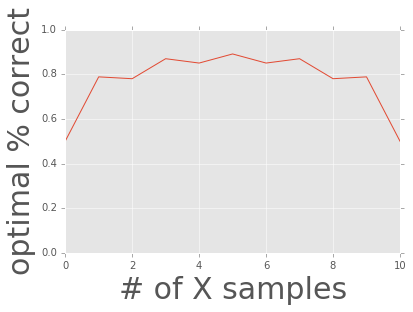

In [43]:
kappa = 10
preds, lams, plot = get_preds(kappa, cat_A, cat_B, p, p0, plot=True)

It would also be great to understand the decision variable for arbitrary categories. Here is what I have so far:

Since the decision variable is just the difference in the log likelihood ratios, with some algebra we can rewrite it in a somewhat more intuitive form:

Let d00 = pA_00 - pB_00, etc...

Let sum_k = k_X + k_Y

Let diff_k = k_X - k_Y

Then d (the decision variable) is 0 iff

d11 * (p^sum_k * (1 - p)^(kappa - sum_k)) + d00 * (p^(kappa - sum_k) * (1 - p)^sum_k) = -(d01 * (p^(-diff_k + N_X) * (1 - p)^(diff_k + N_Y)) + d10 * (p^(diff_k + N_Y) * (1 - p)^(-diff_k + N_X)))

The decision variable favoring one category or the other seems to have to do with the likelihood of both variables taking on the same value under both categories and comparing that with the likelihood that they take on different values. Not sure if this makes any sense though...

Also, I've been trying to understand the spikiness of the loss function. It turns out that in categories where the optimal thing to do is to put all the samples on one dimension, 
there are "plateaus" in the loss function where pairs of values will have the exact same expected percent correct.
Here's an example of a category structure where this is true:

Category A is:  [[0.65749545416973509, 0.24250454583026498], [0.042504545830264945, 0.057495454169735047]]
Category B is:  [[0.097495454169735013, 0.0025045458302649544], [0.60250454583026491, 0.29749545416973505]]

For this number of X samples, the expected percent correct is 
0  X samples:  0.884334848
1  X samples:  0.884334848
2  X samples:  0.8733248
3  X samples:  0.8733248
4  X samples:  0.853664
5  X samples:  0.853664
6  X samples:  0.8168
7  X samples:  0.8168
8  X samples:  0.74
9  X samples:  0.74
10  X samples:  0.5


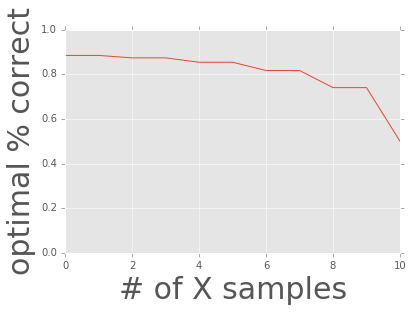

In [54]:
A_X = .3 
A_Y = .1
A_rho = .2 #correlation

B_X = .3 
B_Y = .9
B_rho = .2

cat_A = get_cat(A_X, A_Y, A_rho)
cat_B = get_cat(B_X, B_Y, B_rho)
print "Category A is: ", cat_A
print "Category B is: ", cat_B
preds, lams, plot = get_preds(kappa, cat_A, cat_B, p, p0, plot=True)
print ""
print "For this number of X samples, the expected percent correct is "
for lam in lams:
    print lam, " X samples: ", preds[lam]